# 1.0 Descriptor of FL

We first introduce how we describe FL in our framework. We use the API ```flgo.init``` to create a federated runner to finish a run of FL, which is described as below:

```
def init(task: str, algorithm, option = {}, model=None, Logger: flgo.experiment.logger.BasicLogger = flgo.experiment.logger.simple_logger.SimpleLogger, Simulator: BasicSimulator=flgo.simulator.DefaultSimulator, scene='horizontal'):
    r"""
    Initialize a runner in FLGo, which is to optimize a model on a specific task (i.e. IID-mnist-of-100-clients) by the selected federated algorithm.
    :param
        task (str): the dictionary of the federated task
        algorithm (module || class): the algorithm will be used to optimize the model in federated manner, which must contain pre-defined attributions (e.g. algorithm.Server and algorithm.Client for horizontal federated learning)
        option (dict || str): the configurations of training, environment, algorithm, logger and simulator
        model (module || class): the model module that contains two methods: model.init_local_module(object) and model.init_global_module(object)
        Logger (class): the class of the logger inherited from flgo.experiment.logger.BasicLogger
        Simulator (class): the class of the simulator inherited from flgo.simulator.BasicSimulator
        scene (str): 'horizontal' or 'vertical' in current version of FLGo
    :return
        runner: the object instance that has the method runner.run()
    """
    ...
```

Each run of a federated training process aims to optimize a given **model** on a specific **task** by using an **algorithm** with some hyper-parameter (i.e. **option**) under a particular environment (e.g. **scene**, **hardware condition**).

The term **model** usually shares the same meaning with centralized ML. The term **task** describes how the datasets are distributed among clients and some task-specific configuration (e.g. the dataset information, the target). **Algorithm** is the used optimization strategy and **option** contains several running-time option like learning rate and the number of training rounds. The **hardware condition** is simulated by the **Simulator**. For example, different clients may have different computing power, network latency, communication bandwidth. Finally, the **scene** refers to the four main paradigm in FL: Horizontal FL, Vertical FL, Decentralized FL and Hierarchical FL, as shown in Figure 1. 

- **(a) Horizontal FL**: a server coordinates different clients to collaboratively train the model. Particularly, each clients owns different samples, and each sample is with full features and labels.
- **(b) Vertical FL**: an active party (i.e. label owner) coordinates other passive parties to improve the model performance for its local objective. Particularly, different parties own different dimensions of the feature of each sample, and different data owners will shares a set of the same sample IDs. 
- **(c) Hierarchical FL**: edge servers are responsible for coordinating their themselves clients, and a global server coordinates different edge servers to train the model.
- **(d) Decentralized FL**: clients directly communicates with other clients to collaboratively maintain a global model or improve their own local models under specific communication protocols (e.g. line, ring, full). 


![Figure_1](https://github.com/WwZzz/myfigs/blob/master/figure_scene_in_fl.png?raw=true)

Finally, from the view of doing experiments, we add the term **Logger** to customizely log the variables of interest (e.g. model checkpoints, training-time performance). Some options of experiments (e.g. device, the number of processes) are also contained in the term **option**.

# 1.1 Option Configuration

The full options are shown as below

| Category         | Name                | Type      | Description                                                                                    | Default Value | Comment                                                                 |
|------------------|---------------------|-----------|------------------------------------------------------------------------------------------------|---------------|-------------------------------------------------------------------------|
|  **Training Option** | num_rounds          | int       | number of communication rounds                                                                 | 20            |                                                                         |
|                  | proportion          | float     | proportion of clients sampled per round                                                        | 0.2           |                                                                         |
|                  | learning_rate_decay | float     | learning rate decay for the training process                                                   | 0.998         | effective if lr_scheduler>-1                                            |
|                  | lr_scheduler        | int       | type of the global learning rate scheduler                                                     | -1            | effective if larger than -1                                             |
|                  | early_stop          | int       | stop training if there is no improvement  for no smaller than the maximum rounds               | -1            | effective if larger than -1                                             |
|                  | num_epochs          | int       | number of epochs of local training                                                             | 5             |                                                                         |
|                  | num_steps           | int       | number of steps of local training,  conflict with num_epochs                                   | -1            | dominates num_epochs if larger than 0                                   |
|                  | learning_rate       | float     | learning rate of local training                                                                | 0.1           |                                                                         |
|                  | batch_size          | int\float | batch size of local training                                                                   | 64            | -1 means full batch, float value  means the ratio of the full datasets  |
|                  | optimizer           | str       | to select the optimizer of local training                                                      | 'sgd'         | 'sgd','adam','rmsprop','adagrad'                                        |
|                  | clip_grad           | float     | clipping gradients if the max norm of  gradients \|\|g\|\| > clip_norm > 0                     | 0.0           | effective if larger than 0.0                                            |
|                  | momentum            | float     | momentum of local training                                                                     | 0.0           |                                                                         |
|                  | weight_decay        | float     | weight decay of local training                                                                 | 0.0           |                                                                         |
|                  | num_edge_rounds     | int       | number of edge rounds in hierFL                                                                | 5             | effective if scene is 'hierarchical'                                    |
|                  | algo_para           | int\list  | algorithm-specific hyper-parameters                                                            | []            | the order should be consistent with  the claim                          |
|                  | sample              | str       | to select sampling form                                                                        | 'uniform'     | 'uniform', 'md', 'full',  x+'_with_availability'                        |
|                  | aggregate           | str       | to select aggregation form                                                                     | 'other'       | 'uniform', 'weighted_com',  'weighted_scale', 'other'                   |
| **External Option**  | train_holdout       | float     | the rate of holding out the validation  dataset from all the local training datasets           | 0.1           |                                                                         |
|                  | test_holdout        | float     | the rate of holding out the validation  dataset from the testing datasets owned by  the server | 0.0           | effective if the server has  no validation data                         |
|                  | local_test          | bool      | the local validation data will be equally  split into validation and testing parts  if True    | False         |                                                                         |
|                  | seed                | int       | seed for all the random modules                                                                | 0             |                                                                         |
|                  | gpu                 | int\list  | GPU IDs and empty input means using CPU                                                        | []            |                                                                         |
|                  | server_with_cpu     | bool      | the model parameters will be stored in  the memory if True                                     | False         |                                                                         |
|                  | num_parallels       | int       | the number of parallels during communications                                                  | 1             |                                                                         |
|                  | num_workers         | int       | the number of workers of DataLoader                                                            | 0             |                                                                         |
|                  | pin_memory          | bool      | 1)pin_memory of DataLoader, and 2) load  data directly into memory                             | False         |                                                                         |
|                  | test_batch_size     | int       | the batch_size used in testing phase                                                           | 512           |                                                                         |
| **Simulator Option** | availability        | str       | to select client availability mode                                                             | 'IDL'         | 'IDL','YMF','MDF','LDF','YFF', 'HOMO','LN','SLN','YC'                   |
|                  | connectivity        | str       | to select client connectivity mode                                                             | 'IDL'         | 'IDL','HOMO'                                                            |
|                  | completeness        | str       | to select client completeness mode                                                             | 'IDL'         | 'IDL','PDU','FSU','ADU','ASU'                                           |
|                  | responsiveness      | str       | to select client responsiveness mode                                                           | 'IDL'         | 'IDL','LN','UNI'                                                        |
| **Logger Option**    | log_level           | str       | the level of logger                                                                            | 'INFO'        | 'INFO','DEBUG'                                                          |
|                  | log_file            | bool      | whether log to file and default  value is False                                                | False         |                                                                         |
|                  | no_log_console      | bool      | whether log to screen and default  value is True                                               | True          |                                                                         |
|                  | no_overwrite        | bool      | whether to overwrite the old result                                                            | False         |                                                                         |
|                  | eval_interval       | int       | evaluate every __ rounds;                                                                      | 1             |                                                                         |

# 1.2 Task Configuration

This section introduces the definition of a federated task and how to run algorihms on different tasks in our frameworks. A federated task is defined as **optimizing an objective on a given data distribution**. 

Concretely, **the objective** is defined by the dataset, the objective function, and the evaluation metrics, and each benchmark module is consist of these three terms. For example, the benchmark `flgo.benchmark.mnist_classification` requires a model to perform correct classification on hand written digits images, which is evaluated by the accuracy. 

On the other hand, the **data distribution** suggests how the data is distributed among participants. For example, each participent may owns data that is identically and independently sampled from a global dataset, which is called the i.i.d. case. In our framework, `Paritioner` is responsible for creating such data distributions.

In our framework, we use the configuration of `benchmark` and `partitioner` to generate federated tasks. We now take a example to show how to write configurations to generate different data distributions on the same given benchmark.

## 1.2.1 Example: MNIST classification under different data distributions

Firstly, each config is of the type `dict` in python. The key 'benchmark' and 'partitioner' repsectively specify the information about the aforementioned benchmark and Partitioner.

In [1]:
import flgo
flgo.set_data_root('cwd') # change the directory storing raw data to the current working directory
import flgo.benchmark.mnist_classification as mnist
import flgo.algorithm.fedavg as fedavg
import flgo.benchmark.partition
import os
# DiversityPartitioner will allocate the data to clients w.r.t. data diversity (e.g. here is label diversity)
# DirichletPartitioner will allocate the data to clients w.r.t. dirichlet distribution on specific attr. (e.g. here is also label)
config_iid = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.IIDPartitioner,'para':{'num_clients':100}}}
config_div01 = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.DiversityPartitioner,'para':{'num_clients':100, 'diversity':0.1}}}
config_div05 = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.DiversityPartitioner,'para':{'num_clients':100, 'diversity':0.5}}}
config_div09 = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.DiversityPartitioner,'para':{'num_clients':100, 'diversity':0.9}}}
config_dir01 = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.DirichletPartitioner,'para':{'num_clients':100, 'alpha':0.1}}}
config_dir10 = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.DirichletPartitioner,'para':{'num_clients':100, 'alpha':1.0}}}
config_dir50 = {'benchmark':mnist,'partitioner':{'name': flgo.benchmark.partition.DirichletPartitioner,'para':{'num_clients':100, 'alpha':5.0}}}
task_dict = {
    './mnist_iid': config_iid,
    './mnist_div01': config_div01,
    './mnist_div05': config_div05,
    './mnist_div09': config_div09,
    './mnist_dir01': config_dir01,
    './mnist_dir10': config_dir10,
    './mnist_dir50': config_dir50,
}

for task in task_dict:
    if not os.path.exists(task):
        flgo.gen_task(task_dict[task], task)

Data root directory has successfully been changed to /home/wz/xw_d2l/Jupyter


Secondly, use FedAvg to optimize these tasks with the same hyper-parameters. Note that each benchmark will be attached with a default model (e.g. a predefined CNN for mnist_classification), and initialization without specifying model will automatically load the default model.

In [2]:
import flgo.algorithm.fedavg as fedavg
option = {'gpu':0, 'num_rounds':20, 'num_epochs':1, 'learning_rate':0.1, 'batch_size':64, 'eval_interval':2}
runners = [flgo.init(task, fedavg, option) for task in task_dict]
for runner in runners:
    runner.run()

2023-08-11 08:54:00,101 fflow.py init [line:545] INFO Initializing devices: cuda:0 will be used for this running.
2023-08-11 08:54:00,102 fflow.py init [line:547] INFO BENCHMARK:	flgo.benchmark.mnist_classification
2023-08-11 08:54:00,103 fflow.py init [line:548] INFO TASK:			./mnist_iid
2023-08-11 08:54:00,104 fflow.py init [line:549] INFO MODEL:		flgo.benchmark.mnist_classification.model.cnn
2023-08-11 08:54:00,105 fflow.py init [line:550] INFO ALGORITHM:	fedavg
2023-08-11 08:54:00,387 fflow.py init [line:584] INFO SCENE:		horizontal FL with 1 <class 'flgo.algorithm.fedbase.BasicServer'>, 100 <class 'flgo.algorithm.fedbase.BasicClient'>
2023-08-11 08:54:06,492 fflow.py init [line:604] INFO SIMULATOR:	<class 'flgo.simulator.default_simulator.Simulator'>
2023-08-11 08:54:06,494 fflow.py init [line:613] INFO Ready to start.
2023-08-11 08:54:06,498 fflow.py init [line:545] INFO Initializing devices: cuda:0 will be used for this running.
2023-08-11 08:54:06,498 fflow.py init [line:547] IN

2023-08-11 08:54:23,940 fedbase.py run [line:246] INFO --------------Round 4--------------
2023-08-11 08:54:23,941 simple_logger.py log_once [line:14] INFO Current_time:4
2023-08-11 08:54:27,200 simple_logger.py log_once [line:28] INFO test_accuracy                 0.8767
2023-08-11 08:54:27,201 simple_logger.py log_once [line:28] INFO test_loss                     0.4331
2023-08-11 08:54:27,202 simple_logger.py log_once [line:28] INFO val_accuracy                  0.8633
2023-08-11 08:54:27,203 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.8633
2023-08-11 08:54:27,203 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.0463
2023-08-11 08:54:27,204 simple_logger.py log_once [line:28] INFO val_loss                      0.4573
2023-08-11 08:54:27,205 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.4573
2023-08-11 08:54:27,205 simple_logger.py log_once [line:28] INFO std_val_loss                  0.0911
2023-08-11 08

2023-08-11 08:55:21,516 fedbase.py run [line:246] INFO --------------Round 18--------------
2023-08-11 08:55:21,517 simple_logger.py log_once [line:14] INFO Current_time:18
2023-08-11 08:55:24,776 simple_logger.py log_once [line:28] INFO test_accuracy                 0.9684
2023-08-11 08:55:24,776 simple_logger.py log_once [line:28] INFO test_loss                     0.1018
2023-08-11 08:55:24,777 simple_logger.py log_once [line:28] INFO val_accuracy                  0.9647
2023-08-11 08:55:24,778 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.9647
2023-08-11 08:55:24,778 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.0228
2023-08-11 08:55:24,779 simple_logger.py log_once [line:28] INFO val_loss                      0.1216
2023-08-11 08:55:24,780 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.1216
2023-08-11 08:55:24,780 simple_logger.py log_once [line:28] INFO std_val_loss                  0.0675
2023-08-11 

2023-08-11 08:56:11,494 fedbase.py run [line:246] INFO --------------Round 9--------------
2023-08-11 08:56:13,916 fedbase.py run [line:246] INFO --------------Round 10--------------
2023-08-11 08:56:13,917 simple_logger.py log_once [line:14] INFO Current_time:10
2023-08-11 08:56:17,174 simple_logger.py log_once [line:28] INFO test_accuracy                 0.2618
2023-08-11 08:56:17,174 simple_logger.py log_once [line:28] INFO test_loss                     2.1486
2023-08-11 08:56:17,175 simple_logger.py log_once [line:28] INFO val_accuracy                  0.2600
2023-08-11 08:56:17,176 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.2549
2023-08-11 08:56:17,176 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3953
2023-08-11 08:56:17,177 simple_logger.py log_once [line:28] INFO val_loss                      2.1518
2023-08-11 08:56:17,178 simple_logger.py log_once [line:28] INFO mean_val_loss                 2.1551
2023-08-11 08:56:17,17

2023-08-11 08:57:01,617 fedbase.py run [line:239] INFO Eval Time Cost:               3.2580s
2023-08-11 08:57:04,142 fedbase.py run [line:246] INFO --------------Round 1--------------
2023-08-11 08:57:06,804 fedbase.py run [line:246] INFO --------------Round 2--------------
2023-08-11 08:57:06,805 simple_logger.py log_once [line:14] INFO Current_time:2
2023-08-11 08:57:10,053 simple_logger.py log_once [line:28] INFO test_accuracy                 0.6785
2023-08-11 08:57:10,054 simple_logger.py log_once [line:28] INFO test_loss                     1.9032
2023-08-11 08:57:10,054 simple_logger.py log_once [line:28] INFO val_accuracy                  0.6665
2023-08-11 08:57:10,055 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.6658
2023-08-11 08:57:10,055 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.1071
2023-08-11 08:57:10,056 simple_logger.py log_once [line:28] INFO val_loss                      1.9094
2023-08-11 08:57:10,057 simple_lo

2023-08-11 08:57:58,182 fedbase.py run [line:251] INFO Eval Time Cost:               3.2551s
2023-08-11 08:58:00,464 fedbase.py run [line:246] INFO --------------Round 15--------------
2023-08-11 08:58:02,724 fedbase.py run [line:246] INFO --------------Round 16--------------
2023-08-11 08:58:02,725 simple_logger.py log_once [line:14] INFO Current_time:16
2023-08-11 08:58:06,002 simple_logger.py log_once [line:28] INFO test_accuracy                 0.9536
2023-08-11 08:58:06,004 simple_logger.py log_once [line:28] INFO test_loss                     0.1576
2023-08-11 08:58:06,005 simple_logger.py log_once [line:28] INFO val_accuracy                  0.9514
2023-08-11 08:58:06,006 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.9515
2023-08-11 08:58:06,006 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.0299
2023-08-11 08:58:06,007 simple_logger.py log_once [line:28] INFO val_loss                      0.1744
2023-08-11 08:58:06,008 simple

2023-08-11 08:58:49,812 simple_logger.py log_once [line:28] INFO std_val_loss                  0.0839
2023-08-11 08:58:49,812 fedbase.py run [line:251] INFO Eval Time Cost:               3.2542s
2023-08-11 08:58:52,095 fedbase.py run [line:246] INFO --------------Round 7--------------
2023-08-11 08:58:54,640 fedbase.py run [line:246] INFO --------------Round 8--------------
2023-08-11 08:58:54,641 simple_logger.py log_once [line:14] INFO Current_time:8
2023-08-11 08:58:57,922 simple_logger.py log_once [line:28] INFO test_accuracy                 0.9415
2023-08-11 08:58:57,924 simple_logger.py log_once [line:28] INFO test_loss                     0.1984
2023-08-11 08:58:57,925 simple_logger.py log_once [line:28] INFO val_accuracy                  0.9329
2023-08-11 08:58:57,925 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.9329
2023-08-11 08:58:57,926 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.0304
2023-08-11 08:58:57,927 simple_lo

2023-08-11 08:59:47,515 simple_logger.py log_once [line:28] INFO std_val_loss                  0.0668
2023-08-11 08:59:47,515 fedbase.py run [line:251] INFO Eval Time Cost:               3.2799s
2023-08-11 08:59:47,516 fedbase.py run [line:257] INFO =================End==================
2023-08-11 08:59:47,517 fedbase.py run [line:258] INFO Total Time Cost:              85.3933s
2023-08-11 08:59:47,518 fedbase.py run [line:236] INFO --------------Initial Evaluation--------------
2023-08-11 08:59:47,519 simple_logger.py log_once [line:14] INFO Current_time:0
2023-08-11 08:59:50,784 simple_logger.py log_once [line:28] INFO test_accuracy                 0.0845
2023-08-11 08:59:50,785 simple_logger.py log_once [line:28] INFO test_loss                     2.3038
2023-08-11 08:59:50,785 simple_logger.py log_once [line:28] INFO val_accuracy                  0.0818
2023-08-11 08:59:50,786 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.0815
2023-08-11 08:59:50,786 sim

2023-08-11 09:00:40,651 simple_logger.py log_once [line:28] INFO mean_val_loss                 1.0342
2023-08-11 09:00:40,652 simple_logger.py log_once [line:28] INFO std_val_loss                  0.5055
2023-08-11 09:00:40,652 fedbase.py run [line:251] INFO Eval Time Cost:               3.2899s
2023-08-11 09:00:43,063 fedbase.py run [line:246] INFO --------------Round 13--------------
2023-08-11 09:00:45,198 fedbase.py run [line:246] INFO --------------Round 14--------------
2023-08-11 09:00:45,199 simple_logger.py log_once [line:14] INFO Current_time:14
2023-08-11 09:00:48,441 simple_logger.py log_once [line:28] INFO test_accuracy                 0.8010
2023-08-11 09:00:48,441 simple_logger.py log_once [line:28] INFO test_loss                     0.9624
2023-08-11 09:00:48,442 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7933
2023-08-11 09:00:48,443 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7934
2023-08-11 09:00:48,443 simple

2023-08-11 09:01:32,300 simple_logger.py log_once [line:28] INFO val_loss                      1.4368
2023-08-11 09:01:32,301 simple_logger.py log_once [line:28] INFO mean_val_loss                 1.4367
2023-08-11 09:01:32,302 simple_logger.py log_once [line:28] INFO std_val_loss                  0.2838
2023-08-11 09:01:32,302 fedbase.py run [line:251] INFO Eval Time Cost:               3.2861s
2023-08-11 09:01:34,581 fedbase.py run [line:246] INFO --------------Round 5--------------
2023-08-11 09:01:36,997 fedbase.py run [line:246] INFO --------------Round 6--------------
2023-08-11 09:01:36,999 simple_logger.py log_once [line:14] INFO Current_time:6
2023-08-11 09:01:40,271 simple_logger.py log_once [line:28] INFO test_accuracy                 0.6981
2023-08-11 09:01:40,271 simple_logger.py log_once [line:28] INFO test_loss                     0.9364
2023-08-11 09:01:40,272 simple_logger.py log_once [line:28] INFO val_accuracy                  0.6947
2023-08-11 09:01:40,273 simple_lo

2023-08-11 09:02:28,680 simple_logger.py log_once [line:28] INFO val_loss                      0.2227
2023-08-11 09:02:28,681 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.2227
2023-08-11 09:02:28,681 simple_logger.py log_once [line:28] INFO std_val_loss                  0.1113
2023-08-11 09:02:28,682 fedbase.py run [line:251] INFO Eval Time Cost:               3.2707s
2023-08-11 09:02:30,963 fedbase.py run [line:246] INFO --------------Round 19--------------
2023-08-11 09:02:33,496 fedbase.py run [line:246] INFO --------------Round 20--------------
2023-08-11 09:02:33,496 simple_logger.py log_once [line:14] INFO Current_time:20
2023-08-11 09:02:36,884 simple_logger.py log_once [line:28] INFO test_accuracy                 0.9364
2023-08-11 09:02:36,885 simple_logger.py log_once [line:28] INFO test_loss                     0.2030
2023-08-11 09:02:36,886 simple_logger.py log_once [line:28] INFO val_accuracy                  0.9288
2023-08-11 09:02:36,886 simple

2023-08-11 09:03:20,217 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.0362
2023-08-11 09:03:20,218 simple_logger.py log_once [line:28] INFO val_loss                      0.2414
2023-08-11 09:03:20,218 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.2414
2023-08-11 09:03:20,219 simple_logger.py log_once [line:28] INFO std_val_loss                  0.1035
2023-08-11 09:03:20,220 fedbase.py run [line:251] INFO Eval Time Cost:               3.2646s
2023-08-11 09:03:22,754 fedbase.py run [line:246] INFO --------------Round 11--------------
2023-08-11 09:03:25,158 fedbase.py run [line:246] INFO --------------Round 12--------------
2023-08-11 09:03:25,159 simple_logger.py log_once [line:14] INFO Current_time:12
2023-08-11 09:03:28,425 simple_logger.py log_once [line:28] INFO test_accuracy                 0.9471
2023-08-11 09:03:28,426 simple_logger.py log_once [line:28] INFO test_loss                     0.1817
2023-08-11 09:03:28,427 simple

Thirdly, use `flgo.experiment.analyzer` to read the records and visuazlie the results.

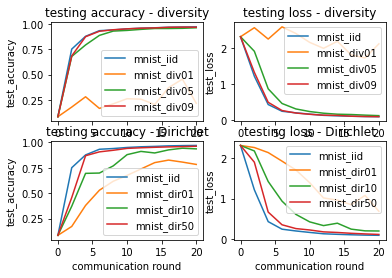

In [3]:
import flgo.experiment.analyzer as al
import matplotlib.pyplot as plt
div_recs = al.Selector({'task':[t for t in task_dict if 'iid' in t or 'div' in t], 'header':['fedavg']})

plt.subplot(221)
for task in div_recs.tasks:
    rec_list = div_recs.records[task]
    for rec in rec_list:
        plt.plot(rec.data['communication_round'], rec.data['test_accuracy'], label=task.split('/')[-1])
plt.title('testing accuracy - diversity')
plt.ylabel('test_accuracy')
plt.xlabel('communication round')
plt.legend()

plt.subplot(222)
for task in div_recs.tasks:
    rec_list = div_recs.records[task]
    for rec in rec_list:
        plt.plot(rec.data['communication_round'], rec.data['test_loss'], label=task.split('/')[-1])
plt.title('testing loss - diversity')
plt.ylabel('test_loss')
plt.xlabel('communication round')
plt.legend()

plt.subplot(223)
dir_recs = al.Selector({'task':[task for task in task_dict if 'iid' in task or 'dir' in task], 'header':['fedavg']})
for task in dir_recs.tasks:
    rec_list = dir_recs.records[task]
    for rec in rec_list:
        plt.plot(rec.data['communication_round'], rec.data['test_accuracy'], label=task.split('/')[-1])
plt.title('testing accuracy - Dirichlet')
plt.ylabel('test_accuracy')
plt.xlabel('communication round')
plt.legend()

plt.subplot(224)
dir_recs = al.Selector({'task':[task for task in task_dict if 'iid' in task or 'dir' in task], 'header':['fedavg']})
for task in dir_recs.tasks:
    rec_list = dir_recs.records[task]
    for rec in rec_list:
        plt.plot(rec.data['communication_round'], rec.data['test_loss'], label=task.split('/')[-1])
plt.title('testing loss - Dirichlet')
plt.ylabel('test_loss')
plt.xlabel('communication round')
plt.legend()
plt.show()

# 1.3 Algorithm Configuration

This section introduces how to change algorithms on the same federated task. In our framework, the algorithm object describes the behaviors of participants in the FL system. For example, the server of horizontal FL usually samples clients, broadcasts the global model to them, and aggregates the collected models from them, where there exist a plenty of different strategies to improve each step. Now we compare a heterogeneous-aware FL algorithm, FedProx, against FedAvg under the same task to show the usage of algorihm.

## 1.3.1 Example: Comparison on FedAvg and FedProx

### Dataset: Synthetic(0.5, 0.5)

We conduct the experiments that shares the same setting in []. Firstly, we generate synthetic datasets with 30 clients. This dataset is generated by 

$$    y_{k,i}=\text{argmax}\{softmax({W_k} x_{k,i}+ b_k)\}$$

where $(x_{k,i}, y_{k,i})$ is the $i$th example in the local data $D_k$ of client $c_k$. For each client $c_k$, its local optimal model parameter $(W_k, b_k)$ is generated by $\mu_k\sim \mathcal{N}(0,\alpha)\in \mathbb{R},W_{k}[i,j]\sim\mathcal{N}(\mu_k,1),  W_k\in \mathbb{R}^{10\times 60}, b_{k}[i]\sim\mathcal{N}(\mu_k,1), b_k\in\mathbb{R}^{10}$, and its local data distribution is generated by $B_k\sim\mathcal{N}(0,\beta),  v_k[i]\sim\mathcal{N}(B_k,1),  v_k\in \mathbb{R}^{60}, x_{k,i}\sim\mathcal{N}(v_k, \Sigma)\in \mathbb{R}^{60},\Sigma=\text{diag}(\{i^{-1.2}\}_{i=1}^{60})$. Here we conduct experiments on Synthetic(0.5,0.5) where $\alpha=\beta=0.5$.

In [5]:
import os
import flgo
task = './test_synthetic'
config = {'benchmark':{'name':'flgo.benchmark.synthetic_regression', 'para':{'alpha':0.5, 'beta':0.5, 'num_clients':30}}}
if not os.path.exists(task): flgo.gen_task(config, task_path = task)

Task ./test_synthetic has been successfully generated.


### Running two algorithms

In [7]:
import flgo.algorithm.fedprox as fedprox
import flgo.algorithm.fedavg as fedavg

option = {'num_rounds':200, 'num_epochs':5, 'batch_size':10, 'learning_rate':0.1, 'gpu':0}
fedavg_runner = flgo.init(task, fedavg, option=option)
fedprox_runner = flgo.init(task, fedprox, option=option)
fedavg_runner.run()
fedprox_runner.run()

2023-08-11 10:18:59,437 fflow.py init [line:545] INFO Initializing devices: cuda:0 will be used for this running.
2023-08-11 10:18:59,441 fflow.py init [line:547] INFO BENCHMARK:	flgo.benchmark.synthetic_regression
2023-08-11 10:18:59,442 fflow.py init [line:548] INFO TASK:			./test_synthetic
2023-08-11 10:18:59,442 fflow.py init [line:549] INFO MODEL:		flgo.benchmark.synthetic_regression.model.lr
2023-08-11 10:18:59,443 fflow.py init [line:550] INFO ALGORITHM:	fedavg
2023-08-11 10:18:59,650 fflow.py init [line:584] INFO SCENE:		horizontal FL with 1 <class 'flgo.algorithm.fedbase.BasicServer'>, 30 <class 'flgo.algorithm.fedbase.BasicClient'>
2023-08-11 10:18:59,652 fflow.py init [line:604] INFO SIMULATOR:	<class 'flgo.simulator.default_simulator.Simulator'>
2023-08-11 10:18:59,654 fflow.py init [line:613] INFO Ready to start.
2023-08-11 10:18:59,665 fflow.py init [line:545] INFO Initializing devices: cuda:0 will be used for this running.
2023-08-11 10:18:59,665 fflow.py init [line:547]

2023-08-11 10:19:07,319 simple_logger.py log_once [line:14] INFO Current_time:6
2023-08-11 10:19:07,376 simple_logger.py log_once [line:28] INFO test_accuracy                 0.3828
2023-08-11 10:19:07,376 simple_logger.py log_once [line:28] INFO test_loss                     1.7843
2023-08-11 10:19:07,377 simple_logger.py log_once [line:28] INFO val_accuracy                  0.3706
2023-08-11 10:19:07,378 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.3706
2023-08-11 10:19:07,379 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3582
2023-08-11 10:19:07,379 simple_logger.py log_once [line:28] INFO val_loss                      1.7666
2023-08-11 10:19:07,380 simple_logger.py log_once [line:28] INFO mean_val_loss                 1.7666
2023-08-11 10:19:07,381 simple_logger.py log_once [line:28] INFO std_val_loss                  0.9474
2023-08-11 10:19:07,382 fedbase.py run [line:251] INFO Eval Time Cost:               0.0627s
2023-08-11 

2023-08-11 10:19:16,766 simple_logger.py log_once [line:28] INFO mean_val_loss                 1.6230
2023-08-11 10:19:16,767 simple_logger.py log_once [line:28] INFO std_val_loss                  1.2588
2023-08-11 10:19:16,768 fedbase.py run [line:251] INFO Eval Time Cost:               0.0594s
2023-08-11 10:19:17,683 fedbase.py run [line:246] INFO --------------Round 14--------------
2023-08-11 10:19:17,684 simple_logger.py log_once [line:14] INFO Current_time:14
2023-08-11 10:19:17,740 simple_logger.py log_once [line:28] INFO test_accuracy                 0.5094
2023-08-11 10:19:17,741 simple_logger.py log_once [line:28] INFO test_loss                     1.5544
2023-08-11 10:19:17,742 simple_logger.py log_once [line:28] INFO val_accuracy                  0.5275
2023-08-11 10:19:17,743 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.5275
2023-08-11 10:19:17,743 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3996
2023-08-11 10:19:17,

2023-08-11 10:19:26,623 simple_logger.py log_once [line:28] INFO val_accuracy                  0.5765
2023-08-11 10:19:26,624 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.5765
2023-08-11 10:19:26,625 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3514
2023-08-11 10:19:26,625 simple_logger.py log_once [line:28] INFO val_loss                      1.2183
2023-08-11 10:19:26,626 simple_logger.py log_once [line:28] INFO mean_val_loss                 1.2183
2023-08-11 10:19:26,627 simple_logger.py log_once [line:28] INFO std_val_loss                  1.0276
2023-08-11 10:19:26,627 fedbase.py run [line:251] INFO Eval Time Cost:               0.0598s
2023-08-11 10:19:27,684 fedbase.py run [line:246] INFO --------------Round 22--------------
2023-08-11 10:19:27,684 simple_logger.py log_once [line:14] INFO Current_time:22
2023-08-11 10:19:27,738 simple_logger.py log_once [line:28] INFO test_accuracy                 0.5300
2023-08-11 10:19:27,

2023-08-11 10:19:35,768 fedbase.py run [line:246] INFO --------------Round 29--------------
2023-08-11 10:19:35,769 simple_logger.py log_once [line:14] INFO Current_time:29
2023-08-11 10:19:35,822 simple_logger.py log_once [line:28] INFO test_accuracy                 0.6194
2023-08-11 10:19:35,823 simple_logger.py log_once [line:28] INFO test_loss                     1.1246
2023-08-11 10:19:35,824 simple_logger.py log_once [line:28] INFO val_accuracy                  0.6265
2023-08-11 10:19:35,825 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.6265
2023-08-11 10:19:35,825 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3627
2023-08-11 10:19:35,826 simple_logger.py log_once [line:28] INFO val_loss                      1.1314
2023-08-11 10:19:35,827 simple_logger.py log_once [line:28] INFO mean_val_loss                 1.1314
2023-08-11 10:19:35,827 simple_logger.py log_once [line:28] INFO std_val_loss                  1.0392
2023-08-11 

2023-08-11 10:19:43,695 simple_logger.py log_once [line:28] INFO val_loss                      1.0078
2023-08-11 10:19:43,696 simple_logger.py log_once [line:28] INFO mean_val_loss                 1.0078
2023-08-11 10:19:43,697 simple_logger.py log_once [line:28] INFO std_val_loss                  0.9997
2023-08-11 10:19:43,697 fedbase.py run [line:251] INFO Eval Time Cost:               0.0467s
2023-08-11 10:19:44,860 fedbase.py run [line:246] INFO --------------Round 37--------------
2023-08-11 10:19:44,861 simple_logger.py log_once [line:14] INFO Current_time:37
2023-08-11 10:19:44,914 simple_logger.py log_once [line:28] INFO test_accuracy                 0.6706
2023-08-11 10:19:44,915 simple_logger.py log_once [line:28] INFO test_loss                     1.0103
2023-08-11 10:19:44,916 simple_logger.py log_once [line:28] INFO val_accuracy                  0.6735
2023-08-11 10:19:44,916 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.6735
2023-08-11 10:19:44,

2023-08-11 10:19:53,068 simple_logger.py log_once [line:28] INFO test_loss                     0.9782
2023-08-11 10:19:53,068 simple_logger.py log_once [line:28] INFO val_accuracy                  0.6941
2023-08-11 10:19:53,069 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.6941
2023-08-11 10:19:53,070 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3001
2023-08-11 10:19:53,070 simple_logger.py log_once [line:28] INFO val_loss                      0.9272
2023-08-11 10:19:53,071 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.9272
2023-08-11 10:19:53,072 simple_logger.py log_once [line:28] INFO std_val_loss                  1.0540
2023-08-11 10:19:53,072 fedbase.py run [line:251] INFO Eval Time Cost:               0.0596s
2023-08-11 10:19:54,234 fedbase.py run [line:246] INFO --------------Round 45--------------
2023-08-11 10:19:54,235 simple_logger.py log_once [line:14] INFO Current_time:45
2023-08-11 10:19:54,

2023-08-11 10:20:01,909 fedbase.py run [line:251] INFO Eval Time Cost:               0.0590s
2023-08-11 10:20:03,141 fedbase.py run [line:246] INFO --------------Round 52--------------
2023-08-11 10:20:03,142 simple_logger.py log_once [line:14] INFO Current_time:52
2023-08-11 10:20:03,183 simple_logger.py log_once [line:28] INFO test_accuracy                 0.6772
2023-08-11 10:20:03,184 simple_logger.py log_once [line:28] INFO test_loss                     0.9834
2023-08-11 10:20:03,185 simple_logger.py log_once [line:28] INFO val_accuracy                  0.6971
2023-08-11 10:20:03,185 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.6971
2023-08-11 10:20:03,186 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2964
2023-08-11 10:20:03,186 simple_logger.py log_once [line:28] INFO val_loss                      0.9415
2023-08-11 10:20:03,187 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.9415
2023-08-11 10:20:03,

2023-08-11 10:20:11,190 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3039
2023-08-11 10:20:11,191 simple_logger.py log_once [line:28] INFO val_loss                      0.7638
2023-08-11 10:20:11,191 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.7638
2023-08-11 10:20:11,192 simple_logger.py log_once [line:28] INFO std_val_loss                  0.8850
2023-08-11 10:20:11,193 fedbase.py run [line:251] INFO Eval Time Cost:               0.0454s
2023-08-11 10:20:12,290 fedbase.py run [line:246] INFO --------------Round 60--------------
2023-08-11 10:20:12,291 simple_logger.py log_once [line:14] INFO Current_time:60
2023-08-11 10:20:12,344 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7139
2023-08-11 10:20:12,345 simple_logger.py log_once [line:28] INFO test_loss                     0.8325
2023-08-11 10:20:12,346 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7265
2023-08-11 10:20:12,

2023-08-11 10:20:20,800 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7094
2023-08-11 10:20:20,800 simple_logger.py log_once [line:28] INFO test_loss                     0.8626
2023-08-11 10:20:20,801 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7275
2023-08-11 10:20:20,802 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7275
2023-08-11 10:20:20,803 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2852
2023-08-11 10:20:20,803 simple_logger.py log_once [line:28] INFO val_loss                      0.8191
2023-08-11 10:20:20,804 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.8191
2023-08-11 10:20:20,805 simple_logger.py log_once [line:28] INFO std_val_loss                  0.9368
2023-08-11 10:20:20,805 fedbase.py run [line:251] INFO Eval Time Cost:               0.0587s
2023-08-11 10:20:22,048 fedbase.py run [line:246] INFO --------------Round 68--------------

2023-08-11 10:20:29,162 simple_logger.py log_once [line:28] INFO std_val_loss                  0.9508
2023-08-11 10:20:29,163 fedbase.py run [line:251] INFO Eval Time Cost:               0.0588s
2023-08-11 10:20:30,435 fedbase.py run [line:246] INFO --------------Round 75--------------
2023-08-11 10:20:30,435 simple_logger.py log_once [line:14] INFO Current_time:75
2023-08-11 10:20:30,489 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7206
2023-08-11 10:20:30,489 simple_logger.py log_once [line:28] INFO test_loss                     0.8794
2023-08-11 10:20:30,490 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7382
2023-08-11 10:20:30,491 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7382
2023-08-11 10:20:30,491 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2650
2023-08-11 10:20:30,492 simple_logger.py log_once [line:28] INFO val_loss                      0.8151
2023-08-11 10:20:30,

2023-08-11 10:20:39,063 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7314
2023-08-11 10:20:39,063 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2613
2023-08-11 10:20:39,064 simple_logger.py log_once [line:28] INFO val_loss                      0.8239
2023-08-11 10:20:39,065 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.8239
2023-08-11 10:20:39,065 simple_logger.py log_once [line:28] INFO std_val_loss                  1.0334
2023-08-11 10:20:39,066 fedbase.py run [line:251] INFO Eval Time Cost:               0.0584s
2023-08-11 10:20:40,290 fedbase.py run [line:246] INFO --------------Round 83--------------
2023-08-11 10:20:40,291 simple_logger.py log_once [line:14] INFO Current_time:83
2023-08-11 10:20:40,332 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7083
2023-08-11 10:20:40,332 simple_logger.py log_once [line:28] INFO test_loss                     0.8827
2023-08-11 10:20:40,

2023-08-11 10:20:49,092 simple_logger.py log_once [line:14] INFO Current_time:90
2023-08-11 10:20:49,145 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7139
2023-08-11 10:20:49,146 simple_logger.py log_once [line:28] INFO test_loss                     0.8696
2023-08-11 10:20:49,147 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7382
2023-08-11 10:20:49,148 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7382
2023-08-11 10:20:49,148 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2826
2023-08-11 10:20:49,149 simple_logger.py log_once [line:28] INFO val_loss                      0.8450
2023-08-11 10:20:49,150 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.8450
2023-08-11 10:20:49,150 simple_logger.py log_once [line:28] INFO std_val_loss                  1.0873
2023-08-11 10:20:49,151 fedbase.py run [line:251] INFO Eval Time Cost:               0.0586s
2023-08-11

2023-08-11 10:20:57,062 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.8679
2023-08-11 10:20:57,063 simple_logger.py log_once [line:28] INFO std_val_loss                  0.8935
2023-08-11 10:20:57,063 fedbase.py run [line:251] INFO Eval Time Cost:               0.0586s
2023-08-11 10:20:58,331 fedbase.py run [line:246] INFO --------------Round 98--------------
2023-08-11 10:20:58,331 simple_logger.py log_once [line:14] INFO Current_time:98
2023-08-11 10:20:58,384 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7111
2023-08-11 10:20:58,385 simple_logger.py log_once [line:28] INFO test_loss                     0.8133
2023-08-11 10:20:58,386 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7010
2023-08-11 10:20:58,387 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7010
2023-08-11 10:20:58,387 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3096
2023-08-11 10:20:58,

2023-08-11 10:21:07,276 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7637
2023-08-11 10:21:07,277 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7637
2023-08-11 10:21:07,278 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2679
2023-08-11 10:21:07,278 simple_logger.py log_once [line:28] INFO val_loss                      0.7087
2023-08-11 10:21:07,279 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.7087
2023-08-11 10:21:07,280 simple_logger.py log_once [line:28] INFO std_val_loss                  0.7686
2023-08-11 10:21:07,281 fedbase.py run [line:251] INFO Eval Time Cost:               0.0586s
2023-08-11 10:21:08,341 fedbase.py run [line:246] INFO --------------Round 106--------------
2023-08-11 10:21:08,341 simple_logger.py log_once [line:14] INFO Current_time:106
2023-08-11 10:21:08,567 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7517
2023-08-11 10:21:0

2023-08-11 10:21:15,812 fedbase.py run [line:251] INFO Eval Time Cost:               0.0460s
2023-08-11 10:21:17,003 fedbase.py run [line:246] INFO --------------Round 113--------------
2023-08-11 10:21:17,004 simple_logger.py log_once [line:14] INFO Current_time:113
2023-08-11 10:21:17,057 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7733
2023-08-11 10:21:17,058 simple_logger.py log_once [line:28] INFO test_loss                     0.7374
2023-08-11 10:21:17,059 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7971
2023-08-11 10:21:17,059 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7971
2023-08-11 10:21:17,060 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2256
2023-08-11 10:21:17,061 simple_logger.py log_once [line:28] INFO val_loss                      0.6874
2023-08-11 10:21:17,061 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.6874
2023-08-11 10:21:1

2023-08-11 10:21:24,851 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2609
2023-08-11 10:21:24,852 simple_logger.py log_once [line:28] INFO val_loss                      0.7665
2023-08-11 10:21:24,852 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.7665
2023-08-11 10:21:24,853 simple_logger.py log_once [line:28] INFO std_val_loss                  0.9461
2023-08-11 10:21:24,854 fedbase.py run [line:251] INFO Eval Time Cost:               0.0588s
2023-08-11 10:21:26,077 fedbase.py run [line:246] INFO --------------Round 121--------------
2023-08-11 10:21:26,077 simple_logger.py log_once [line:14] INFO Current_time:121
2023-08-11 10:21:26,118 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7711
2023-08-11 10:21:26,119 simple_logger.py log_once [line:28] INFO test_loss                     0.8023
2023-08-11 10:21:26,120 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7686
2023-08-11 10:21:2

2023-08-11 10:21:34,225 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7678
2023-08-11 10:21:34,225 simple_logger.py log_once [line:28] INFO test_loss                     0.7723
2023-08-11 10:21:34,226 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7794
2023-08-11 10:21:34,227 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7794
2023-08-11 10:21:34,227 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2442
2023-08-11 10:21:34,228 simple_logger.py log_once [line:28] INFO val_loss                      0.7763
2023-08-11 10:21:34,229 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.7763
2023-08-11 10:21:34,229 simple_logger.py log_once [line:28] INFO std_val_loss                  1.0168
2023-08-11 10:21:34,230 fedbase.py run [line:251] INFO Eval Time Cost:               0.0585s
2023-08-11 10:21:35,247 fedbase.py run [line:246] INFO --------------Round 129-------------

2023-08-11 10:21:42,776 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.7888
2023-08-11 10:21:42,776 simple_logger.py log_once [line:28] INFO std_val_loss                  1.1781
2023-08-11 10:21:42,777 fedbase.py run [line:251] INFO Eval Time Cost:               0.0590s
2023-08-11 10:21:43,776 fedbase.py run [line:246] INFO --------------Round 136--------------
2023-08-11 10:21:43,777 simple_logger.py log_once [line:14] INFO Current_time:136
2023-08-11 10:21:43,815 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7739
2023-08-11 10:21:43,816 simple_logger.py log_once [line:28] INFO test_loss                     0.8124
2023-08-11 10:21:43,816 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7784
2023-08-11 10:21:43,817 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7784
2023-08-11 10:21:43,818 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2631
2023-08-11 10:21:4

2023-08-11 10:21:52,163 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7892
2023-08-11 10:21:52,164 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7892
2023-08-11 10:21:52,165 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2489
2023-08-11 10:21:52,166 simple_logger.py log_once [line:28] INFO val_loss                      0.7560
2023-08-11 10:21:52,166 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.7560
2023-08-11 10:21:52,167 simple_logger.py log_once [line:28] INFO std_val_loss                  1.1905
2023-08-11 10:21:52,168 fedbase.py run [line:251] INFO Eval Time Cost:               0.0590s
2023-08-11 10:21:53,451 fedbase.py run [line:246] INFO --------------Round 144--------------
2023-08-11 10:21:53,451 simple_logger.py log_once [line:14] INFO Current_time:144
2023-08-11 10:21:53,504 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7656
2023-08-11 10:21:5

2023-08-11 10:21:59,906 fedbase.py run [line:251] INFO Eval Time Cost:               0.0451s
2023-08-11 10:22:01,050 fedbase.py run [line:246] INFO --------------Round 151--------------
2023-08-11 10:22:01,051 simple_logger.py log_once [line:14] INFO Current_time:151
2023-08-11 10:22:01,103 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7378
2023-08-11 10:22:01,104 simple_logger.py log_once [line:28] INFO test_loss                     0.8489
2023-08-11 10:22:01,105 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7549
2023-08-11 10:22:01,106 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7549
2023-08-11 10:22:01,106 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2851
2023-08-11 10:22:01,107 simple_logger.py log_once [line:28] INFO val_loss                      0.8191
2023-08-11 10:22:01,108 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.8191
2023-08-11 10:22:0

2023-08-11 10:22:08,702 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2909
2023-08-11 10:22:08,703 simple_logger.py log_once [line:28] INFO val_loss                      0.8373
2023-08-11 10:22:08,704 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.8373
2023-08-11 10:22:08,704 simple_logger.py log_once [line:28] INFO std_val_loss                  1.1920
2023-08-11 10:22:08,705 fedbase.py run [line:251] INFO Eval Time Cost:               0.0587s
2023-08-11 10:22:09,982 fedbase.py run [line:246] INFO --------------Round 159--------------
2023-08-11 10:22:09,983 simple_logger.py log_once [line:14] INFO Current_time:159
2023-08-11 10:22:10,028 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7400
2023-08-11 10:22:10,029 simple_logger.py log_once [line:28] INFO test_loss                     0.8421
2023-08-11 10:22:10,030 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7471
2023-08-11 10:22:1

2023-08-11 10:22:17,897 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7417
2023-08-11 10:22:17,898 simple_logger.py log_once [line:28] INFO test_loss                     0.8445
2023-08-11 10:22:17,899 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7373
2023-08-11 10:22:17,899 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7373
2023-08-11 10:22:17,900 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2994
2023-08-11 10:22:17,901 simple_logger.py log_once [line:28] INFO val_loss                      0.8329
2023-08-11 10:22:17,901 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.8329
2023-08-11 10:22:17,902 simple_logger.py log_once [line:28] INFO std_val_loss                  0.9848
2023-08-11 10:22:17,903 fedbase.py run [line:251] INFO Eval Time Cost:               0.0585s
2023-08-11 10:22:19,074 fedbase.py run [line:246] INFO --------------Round 167-------------

2023-08-11 10:22:25,859 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.7962
2023-08-11 10:22:25,860 simple_logger.py log_once [line:28] INFO std_val_loss                  1.0880
2023-08-11 10:22:25,861 fedbase.py run [line:251] INFO Eval Time Cost:               0.0586s
2023-08-11 10:22:26,906 fedbase.py run [line:246] INFO --------------Round 174--------------
2023-08-11 10:22:26,907 simple_logger.py log_once [line:14] INFO Current_time:174
2023-08-11 10:22:26,951 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7756
2023-08-11 10:22:26,952 simple_logger.py log_once [line:28] INFO test_loss                     0.7859
2023-08-11 10:22:26,952 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7716
2023-08-11 10:22:26,953 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7716
2023-08-11 10:22:26,954 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2695
2023-08-11 10:22:2

2023-08-11 10:22:35,537 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7627
2023-08-11 10:22:35,537 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7627
2023-08-11 10:22:35,538 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2639
2023-08-11 10:22:35,539 simple_logger.py log_once [line:28] INFO val_loss                      0.7425
2023-08-11 10:22:35,540 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.7425
2023-08-11 10:22:35,540 simple_logger.py log_once [line:28] INFO std_val_loss                  0.8789
2023-08-11 10:22:35,541 fedbase.py run [line:251] INFO Eval Time Cost:               0.0591s
2023-08-11 10:22:36,916 fedbase.py run [line:246] INFO --------------Round 182--------------
2023-08-11 10:22:36,916 simple_logger.py log_once [line:14] INFO Current_time:182
2023-08-11 10:22:36,970 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7550
2023-08-11 10:22:3

2023-08-11 10:22:44,615 fedbase.py run [line:251] INFO Eval Time Cost:               0.0588s
2023-08-11 10:22:45,990 fedbase.py run [line:246] INFO --------------Round 189--------------
2023-08-11 10:22:45,990 simple_logger.py log_once [line:14] INFO Current_time:189
2023-08-11 10:22:46,044 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7328
2023-08-11 10:22:46,045 simple_logger.py log_once [line:28] INFO test_loss                     0.8037
2023-08-11 10:22:46,046 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7520
2023-08-11 10:22:46,046 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7520
2023-08-11 10:22:46,047 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2692
2023-08-11 10:22:46,048 simple_logger.py log_once [line:28] INFO val_loss                      0.7696
2023-08-11 10:22:46,048 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.7696
2023-08-11 10:22:4

2023-08-11 10:22:54,960 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2478
2023-08-11 10:22:54,961 simple_logger.py log_once [line:28] INFO val_loss                      0.7391
2023-08-11 10:22:54,961 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.7391
2023-08-11 10:22:54,962 simple_logger.py log_once [line:28] INFO std_val_loss                  1.0464
2023-08-11 10:22:54,963 fedbase.py run [line:251] INFO Eval Time Cost:               0.0444s
2023-08-11 10:22:55,617 fedbase.py run [line:246] INFO --------------Round 197--------------
2023-08-11 10:22:55,618 simple_logger.py log_once [line:14] INFO Current_time:197
2023-08-11 10:22:55,656 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7589
2023-08-11 10:22:55,656 simple_logger.py log_once [line:28] INFO test_loss                     0.7759
2023-08-11 10:22:55,657 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7598
2023-08-11 10:22:5

2023-08-11 10:23:05,392 fedbase.py run [line:246] INFO --------------Round 3--------------
2023-08-11 10:23:05,393 simple_logger.py log_once [line:14] INFO Current_time:3
2023-08-11 10:23:05,447 simple_logger.py log_once [line:28] INFO test_accuracy                 0.2794
2023-08-11 10:23:05,448 simple_logger.py log_once [line:28] INFO test_loss                     2.1103
2023-08-11 10:23:05,449 simple_logger.py log_once [line:28] INFO val_accuracy                  0.2922
2023-08-11 10:23:05,450 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.2922
2023-08-11 10:23:05,451 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3389
2023-08-11 10:23:05,451 simple_logger.py log_once [line:28] INFO val_loss                      2.0973
2023-08-11 10:23:05,452 simple_logger.py log_once [line:28] INFO mean_val_loss                 2.0973
2023-08-11 10:23:05,453 simple_logger.py log_once [line:28] INFO std_val_loss                  0.6581
2023-08-11 10

2023-08-11 10:23:19,773 simple_logger.py log_once [line:28] INFO val_loss                      1.7005
2023-08-11 10:23:19,774 simple_logger.py log_once [line:28] INFO mean_val_loss                 1.7005
2023-08-11 10:23:19,775 simple_logger.py log_once [line:28] INFO std_val_loss                  1.0229
2023-08-11 10:23:19,776 fedbase.py run [line:251] INFO Eval Time Cost:               0.0597s
2023-08-11 10:23:21,811 fedbase.py run [line:246] INFO --------------Round 11--------------
2023-08-11 10:23:21,812 simple_logger.py log_once [line:14] INFO Current_time:11
2023-08-11 10:23:21,866 simple_logger.py log_once [line:28] INFO test_accuracy                 0.4728
2023-08-11 10:23:21,867 simple_logger.py log_once [line:28] INFO test_loss                     1.5934
2023-08-11 10:23:21,867 simple_logger.py log_once [line:28] INFO val_accuracy                  0.4765
2023-08-11 10:23:21,868 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.4765
2023-08-11 10:23:21,

2023-08-11 10:23:35,324 simple_logger.py log_once [line:28] INFO test_loss                     1.4660
2023-08-11 10:23:35,325 simple_logger.py log_once [line:28] INFO val_accuracy                  0.5225
2023-08-11 10:23:35,326 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.5225
2023-08-11 10:23:35,326 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.4005
2023-08-11 10:23:35,327 simple_logger.py log_once [line:28] INFO val_loss                      1.4598
2023-08-11 10:23:35,328 simple_logger.py log_once [line:28] INFO mean_val_loss                 1.4598
2023-08-11 10:23:35,329 simple_logger.py log_once [line:28] INFO std_val_loss                  1.1368
2023-08-11 10:23:35,329 fedbase.py run [line:251] INFO Eval Time Cost:               0.0597s
2023-08-11 10:23:37,338 fedbase.py run [line:246] INFO --------------Round 19--------------
2023-08-11 10:23:37,339 simple_logger.py log_once [line:14] INFO Current_time:19
2023-08-11 10:23:37,

2023-08-11 10:23:47,810 fedbase.py run [line:251] INFO Eval Time Cost:               0.0590s
2023-08-11 10:23:49,812 fedbase.py run [line:246] INFO --------------Round 26--------------
2023-08-11 10:23:49,813 simple_logger.py log_once [line:14] INFO Current_time:26
2023-08-11 10:23:49,866 simple_logger.py log_once [line:28] INFO test_accuracy                 0.6322
2023-08-11 10:23:49,867 simple_logger.py log_once [line:28] INFO test_loss                     1.0774
2023-08-11 10:23:49,868 simple_logger.py log_once [line:28] INFO val_accuracy                  0.6431
2023-08-11 10:23:49,869 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.6431
2023-08-11 10:23:49,869 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3467
2023-08-11 10:23:49,870 simple_logger.py log_once [line:28] INFO val_loss                      1.0688
2023-08-11 10:23:49,871 simple_logger.py log_once [line:28] INFO mean_val_loss                 1.0688
2023-08-11 10:23:49,

2023-08-11 10:24:03,968 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3251
2023-08-11 10:24:03,969 simple_logger.py log_once [line:28] INFO val_loss                      0.9555
2023-08-11 10:24:03,969 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.9555
2023-08-11 10:24:03,970 simple_logger.py log_once [line:28] INFO std_val_loss                  0.6566
2023-08-11 10:24:03,971 fedbase.py run [line:251] INFO Eval Time Cost:               0.0595s
2023-08-11 10:24:05,639 fedbase.py run [line:246] INFO --------------Round 34--------------
2023-08-11 10:24:05,639 simple_logger.py log_once [line:14] INFO Current_time:34
2023-08-11 10:24:05,693 simple_logger.py log_once [line:28] INFO test_accuracy                 0.6522
2023-08-11 10:24:05,694 simple_logger.py log_once [line:28] INFO test_loss                     0.9719
2023-08-11 10:24:05,695 simple_logger.py log_once [line:28] INFO val_accuracy                  0.6657
2023-08-11 10:24:05,

2023-08-11 10:24:19,502 simple_logger.py log_once [line:28] INFO test_accuracy                 0.6528
2023-08-11 10:24:19,503 simple_logger.py log_once [line:28] INFO test_loss                     0.9346
2023-08-11 10:24:19,504 simple_logger.py log_once [line:28] INFO val_accuracy                  0.6569
2023-08-11 10:24:19,504 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.6569
2023-08-11 10:24:19,505 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3331
2023-08-11 10:24:19,506 simple_logger.py log_once [line:28] INFO val_loss                      0.9205
2023-08-11 10:24:19,507 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.9205
2023-08-11 10:24:19,507 simple_logger.py log_once [line:28] INFO std_val_loss                  0.7205
2023-08-11 10:24:19,508 fedbase.py run [line:251] INFO Eval Time Cost:               0.0592s
2023-08-11 10:24:21,504 fedbase.py run [line:246] INFO --------------Round 42--------------

2023-08-11 10:24:32,619 simple_logger.py log_once [line:28] INFO std_val_loss                  0.8958
2023-08-11 10:24:32,620 fedbase.py run [line:251] INFO Eval Time Cost:               0.0591s
2023-08-11 10:24:34,623 fedbase.py run [line:246] INFO --------------Round 49--------------
2023-08-11 10:24:34,624 simple_logger.py log_once [line:14] INFO Current_time:49
2023-08-11 10:24:34,677 simple_logger.py log_once [line:28] INFO test_accuracy                 0.6861
2023-08-11 10:24:34,678 simple_logger.py log_once [line:28] INFO test_loss                     0.8717
2023-08-11 10:24:34,679 simple_logger.py log_once [line:28] INFO val_accuracy                  0.6912
2023-08-11 10:24:34,680 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.6912
2023-08-11 10:24:34,680 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3225
2023-08-11 10:24:34,681 simple_logger.py log_once [line:28] INFO val_loss                      0.8785
2023-08-11 10:24:34,

2023-08-11 10:24:47,461 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.6931
2023-08-11 10:24:47,462 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.3098
2023-08-11 10:24:47,462 simple_logger.py log_once [line:28] INFO val_loss                      0.7930
2023-08-11 10:24:47,463 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.7930
2023-08-11 10:24:47,464 simple_logger.py log_once [line:28] INFO std_val_loss                  0.6249
2023-08-11 10:24:47,464 fedbase.py run [line:251] INFO Eval Time Cost:               0.0607s
2023-08-11 10:24:49,468 fedbase.py run [line:246] INFO --------------Round 57--------------
2023-08-11 10:24:49,470 simple_logger.py log_once [line:14] INFO Current_time:57
2023-08-11 10:24:49,524 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7039
2023-08-11 10:24:49,525 simple_logger.py log_once [line:28] INFO test_loss                     0.8366
2023-08-11 10:24:49,

2023-08-11 10:25:03,226 simple_logger.py log_once [line:14] INFO Current_time:64
2023-08-11 10:25:03,279 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7494
2023-08-11 10:25:03,280 simple_logger.py log_once [line:28] INFO test_loss                     0.6887
2023-08-11 10:25:03,281 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7676
2023-08-11 10:25:03,282 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7676
2023-08-11 10:25:03,282 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2337
2023-08-11 10:25:03,283 simple_logger.py log_once [line:28] INFO val_loss                      0.6500
2023-08-11 10:25:03,284 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.6500
2023-08-11 10:25:03,284 simple_logger.py log_once [line:28] INFO std_val_loss                  0.5044
2023-08-11 10:25:03,285 fedbase.py run [line:251] INFO Eval Time Cost:               0.0587s
2023-08-11

2023-08-11 10:25:16,748 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.6232
2023-08-11 10:25:16,749 simple_logger.py log_once [line:28] INFO std_val_loss                  0.5498
2023-08-11 10:25:16,750 fedbase.py run [line:251] INFO Eval Time Cost:               0.0587s
2023-08-11 10:25:18,745 fedbase.py run [line:246] INFO --------------Round 72--------------
2023-08-11 10:25:18,745 simple_logger.py log_once [line:14] INFO Current_time:72
2023-08-11 10:25:18,798 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7644
2023-08-11 10:25:18,799 simple_logger.py log_once [line:28] INFO test_loss                     0.6753
2023-08-11 10:25:18,800 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7814
2023-08-11 10:25:18,801 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7814
2023-08-11 10:25:18,801 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2424
2023-08-11 10:25:18,

2023-08-11 10:25:31,906 simple_logger.py log_once [line:28] INFO val_accuracy                  0.8157
2023-08-11 10:25:31,907 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.8157
2023-08-11 10:25:31,907 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2087
2023-08-11 10:25:31,908 simple_logger.py log_once [line:28] INFO val_loss                      0.5851
2023-08-11 10:25:31,909 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.5851
2023-08-11 10:25:31,909 simple_logger.py log_once [line:28] INFO std_val_loss                  0.5481
2023-08-11 10:25:31,910 fedbase.py run [line:251] INFO Eval Time Cost:               0.0591s
2023-08-11 10:25:33,578 fedbase.py run [line:246] INFO --------------Round 80--------------
2023-08-11 10:25:33,579 simple_logger.py log_once [line:14] INFO Current_time:80
2023-08-11 10:25:33,633 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7983
2023-08-11 10:25:33,

2023-08-11 10:25:47,365 fedbase.py run [line:246] INFO --------------Round 87--------------
2023-08-11 10:25:47,366 simple_logger.py log_once [line:14] INFO Current_time:87
2023-08-11 10:25:47,419 simple_logger.py log_once [line:28] INFO test_accuracy                 0.8206
2023-08-11 10:25:47,420 simple_logger.py log_once [line:28] INFO test_loss                     0.6059
2023-08-11 10:25:47,420 simple_logger.py log_once [line:28] INFO val_accuracy                  0.8343
2023-08-11 10:25:47,421 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.8343
2023-08-11 10:25:47,422 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.1861
2023-08-11 10:25:47,423 simple_logger.py log_once [line:28] INFO val_loss                      0.5556
2023-08-11 10:25:47,423 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.5556
2023-08-11 10:25:47,424 simple_logger.py log_once [line:28] INFO std_val_loss                  0.4853
2023-08-11 

2023-08-11 10:26:00,874 simple_logger.py log_once [line:28] INFO val_loss                      0.5453
2023-08-11 10:26:00,875 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.5453
2023-08-11 10:26:00,876 simple_logger.py log_once [line:28] INFO std_val_loss                  0.5003
2023-08-11 10:26:00,876 fedbase.py run [line:251] INFO Eval Time Cost:               0.0590s
2023-08-11 10:26:02,544 fedbase.py run [line:246] INFO --------------Round 95--------------
2023-08-11 10:26:02,545 simple_logger.py log_once [line:14] INFO Current_time:95
2023-08-11 10:26:02,598 simple_logger.py log_once [line:28] INFO test_accuracy                 0.8211
2023-08-11 10:26:02,599 simple_logger.py log_once [line:28] INFO test_loss                     0.5557
2023-08-11 10:26:02,600 simple_logger.py log_once [line:28] INFO val_accuracy                  0.8304
2023-08-11 10:26:02,600 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.8304
2023-08-11 10:26:02,

2023-08-11 10:26:16,716 simple_logger.py log_once [line:28] INFO test_loss                     0.5771
2023-08-11 10:26:16,717 simple_logger.py log_once [line:28] INFO val_accuracy                  0.8108
2023-08-11 10:26:16,717 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.8108
2023-08-11 10:26:16,718 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2089
2023-08-11 10:26:16,719 simple_logger.py log_once [line:28] INFO val_loss                      0.5583
2023-08-11 10:26:16,719 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.5583
2023-08-11 10:26:16,720 simple_logger.py log_once [line:28] INFO std_val_loss                  0.5204
2023-08-11 10:26:16,721 fedbase.py run [line:251] INFO Eval Time Cost:               0.0591s
2023-08-11 10:26:18,383 fedbase.py run [line:246] INFO --------------Round 103--------------
2023-08-11 10:26:18,384 simple_logger.py log_once [line:14] INFO Current_time:103
2023-08-11 10:26:1

2023-08-11 10:26:29,886 simple_logger.py log_once [line:28] INFO std_val_loss                  0.5799
2023-08-11 10:26:29,887 fedbase.py run [line:251] INFO Eval Time Cost:               0.0594s
2023-08-11 10:26:31,562 fedbase.py run [line:246] INFO --------------Round 110--------------
2023-08-11 10:26:31,563 simple_logger.py log_once [line:14] INFO Current_time:110
2023-08-11 10:26:31,616 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7739
2023-08-11 10:26:31,616 simple_logger.py log_once [line:28] INFO test_loss                     0.6332
2023-08-11 10:26:31,617 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7843
2023-08-11 10:26:31,618 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7843
2023-08-11 10:26:31,619 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2451
2023-08-11 10:26:31,619 simple_logger.py log_once [line:28] INFO val_loss                      0.6009
2023-08-11 10:26:3

2023-08-11 10:26:43,037 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.8029
2023-08-11 10:26:43,038 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2180
2023-08-11 10:26:43,038 simple_logger.py log_once [line:28] INFO val_loss                      0.5982
2023-08-11 10:26:43,039 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.5982
2023-08-11 10:26:43,040 simple_logger.py log_once [line:28] INFO std_val_loss                  0.6594
2023-08-11 10:26:43,040 fedbase.py run [line:251] INFO Eval Time Cost:               0.0586s
2023-08-11 10:26:45,038 fedbase.py run [line:246] INFO --------------Round 118--------------
2023-08-11 10:26:45,039 simple_logger.py log_once [line:14] INFO Current_time:118
2023-08-11 10:26:45,092 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7906
2023-08-11 10:26:45,093 simple_logger.py log_once [line:28] INFO test_loss                     0.6303
2023-08-11 10:26:4

2023-08-11 10:26:58,960 simple_logger.py log_once [line:14] INFO Current_time:125
2023-08-11 10:26:59,013 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7761
2023-08-11 10:26:59,014 simple_logger.py log_once [line:28] INFO test_loss                     0.6052
2023-08-11 10:26:59,014 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7873
2023-08-11 10:26:59,015 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7873
2023-08-11 10:26:59,016 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2535
2023-08-11 10:26:59,016 simple_logger.py log_once [line:28] INFO val_loss                      0.6028
2023-08-11 10:26:59,017 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.6028
2023-08-11 10:26:59,018 simple_logger.py log_once [line:28] INFO std_val_loss                  0.6285
2023-08-11 10:26:59,019 fedbase.py run [line:251] INFO Eval Time Cost:               0.0589s
2023-08-1

2023-08-11 10:27:11,468 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.6197
2023-08-11 10:27:11,469 simple_logger.py log_once [line:28] INFO std_val_loss                  0.8031
2023-08-11 10:27:11,469 fedbase.py run [line:251] INFO Eval Time Cost:               0.0604s
2023-08-11 10:27:13,470 fedbase.py run [line:246] INFO --------------Round 133--------------
2023-08-11 10:27:13,471 simple_logger.py log_once [line:14] INFO Current_time:133
2023-08-11 10:27:13,528 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7933
2023-08-11 10:27:13,529 simple_logger.py log_once [line:28] INFO test_loss                     0.6185
2023-08-11 10:27:13,529 simple_logger.py log_once [line:28] INFO val_accuracy                  0.8088
2023-08-11 10:27:13,530 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.8088
2023-08-11 10:27:13,531 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2279
2023-08-11 10:27:1

2023-08-11 10:27:26,631 simple_logger.py log_once [line:28] INFO val_accuracy                  0.7833
2023-08-11 10:27:26,631 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.7833
2023-08-11 10:27:26,632 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2451
2023-08-11 10:27:26,633 simple_logger.py log_once [line:28] INFO val_loss                      0.5965
2023-08-11 10:27:26,633 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.5965
2023-08-11 10:27:26,634 simple_logger.py log_once [line:28] INFO std_val_loss                  0.6059
2023-08-11 10:27:26,635 fedbase.py run [line:251] INFO Eval Time Cost:               0.0590s
2023-08-11 10:27:28,625 fedbase.py run [line:246] INFO --------------Round 141--------------
2023-08-11 10:27:28,626 simple_logger.py log_once [line:14] INFO Current_time:141
2023-08-11 10:27:28,680 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7917
2023-08-11 10:27:2

2023-08-11 10:27:40,049 fedbase.py run [line:251] INFO Eval Time Cost:               0.0593s
2023-08-11 10:27:41,717 fedbase.py run [line:246] INFO --------------Round 148--------------
2023-08-11 10:27:41,718 simple_logger.py log_once [line:14] INFO Current_time:148
2023-08-11 10:27:41,771 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7900
2023-08-11 10:27:41,772 simple_logger.py log_once [line:28] INFO test_loss                     0.5823
2023-08-11 10:27:41,772 simple_logger.py log_once [line:28] INFO val_accuracy                  0.8010
2023-08-11 10:27:41,773 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.8010
2023-08-11 10:27:41,774 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2197
2023-08-11 10:27:41,775 simple_logger.py log_once [line:28] INFO val_loss                      0.5657
2023-08-11 10:27:41,775 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.5657
2023-08-11 10:27:4

2023-08-11 10:27:54,225 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2134
2023-08-11 10:27:54,225 simple_logger.py log_once [line:28] INFO val_loss                      0.5978
2023-08-11 10:27:54,226 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.5978
2023-08-11 10:27:54,227 simple_logger.py log_once [line:28] INFO std_val_loss                  0.6753
2023-08-11 10:27:54,227 fedbase.py run [line:251] INFO Eval Time Cost:               0.0588s
2023-08-11 10:27:56,239 fedbase.py run [line:246] INFO --------------Round 156--------------
2023-08-11 10:27:56,240 simple_logger.py log_once [line:14] INFO Current_time:156
2023-08-11 10:27:56,293 simple_logger.py log_once [line:28] INFO test_accuracy                 0.8072
2023-08-11 10:27:56,294 simple_logger.py log_once [line:28] INFO test_loss                     0.5761
2023-08-11 10:27:56,295 simple_logger.py log_once [line:28] INFO val_accuracy                  0.8314
2023-08-11 10:27:5

2023-08-11 10:28:09,703 simple_logger.py log_once [line:28] INFO test_accuracy                 0.8033
2023-08-11 10:28:09,704 simple_logger.py log_once [line:28] INFO test_loss                     0.5401
2023-08-11 10:28:09,704 simple_logger.py log_once [line:28] INFO val_accuracy                  0.8088
2023-08-11 10:28:09,705 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.8088
2023-08-11 10:28:09,706 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.2049
2023-08-11 10:28:09,707 simple_logger.py log_once [line:28] INFO val_loss                      0.5407
2023-08-11 10:28:09,707 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.5407
2023-08-11 10:28:09,708 simple_logger.py log_once [line:28] INFO std_val_loss                  0.4964
2023-08-11 10:28:09,709 fedbase.py run [line:251] INFO Eval Time Cost:               0.0588s
2023-08-11 10:28:11,378 fedbase.py run [line:246] INFO --------------Round 164-------------

2023-08-11 10:28:23,809 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.4995
2023-08-11 10:28:23,809 simple_logger.py log_once [line:28] INFO std_val_loss                  0.4306
2023-08-11 10:28:23,810 fedbase.py run [line:251] INFO Eval Time Cost:               0.0589s
2023-08-11 10:28:25,479 fedbase.py run [line:246] INFO --------------Round 171--------------
2023-08-11 10:28:25,480 simple_logger.py log_once [line:14] INFO Current_time:171
2023-08-11 10:28:25,533 simple_logger.py log_once [line:28] INFO test_accuracy                 0.8144
2023-08-11 10:28:25,534 simple_logger.py log_once [line:28] INFO test_loss                     0.5266
2023-08-11 10:28:25,534 simple_logger.py log_once [line:28] INFO val_accuracy                  0.8216
2023-08-11 10:28:25,535 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.8216
2023-08-11 10:28:25,536 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.1800
2023-08-11 10:28:2

2023-08-11 10:28:38,989 simple_logger.py log_once [line:28] INFO val_accuracy                  0.8294
2023-08-11 10:28:38,990 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.8294
2023-08-11 10:28:38,991 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.1807
2023-08-11 10:28:38,991 simple_logger.py log_once [line:28] INFO val_loss                      0.5101
2023-08-11 10:28:38,992 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.5101
2023-08-11 10:28:38,993 simple_logger.py log_once [line:28] INFO std_val_loss                  0.4815
2023-08-11 10:28:38,993 fedbase.py run [line:251] INFO Eval Time Cost:               0.0592s
2023-08-11 10:28:41,035 fedbase.py run [line:246] INFO --------------Round 179--------------
2023-08-11 10:28:41,037 simple_logger.py log_once [line:14] INFO Current_time:179
2023-08-11 10:28:41,092 simple_logger.py log_once [line:28] INFO test_accuracy                 0.8072
2023-08-11 10:28:4

2023-08-11 10:28:52,819 fedbase.py run [line:251] INFO Eval Time Cost:               0.0589s
2023-08-11 10:28:54,816 fedbase.py run [line:246] INFO --------------Round 186--------------
2023-08-11 10:28:54,817 simple_logger.py log_once [line:14] INFO Current_time:186
2023-08-11 10:28:54,870 simple_logger.py log_once [line:28] INFO test_accuracy                 0.7867
2023-08-11 10:28:54,871 simple_logger.py log_once [line:28] INFO test_loss                     0.5933
2023-08-11 10:28:54,872 simple_logger.py log_once [line:28] INFO val_accuracy                  0.8108
2023-08-11 10:28:54,872 simple_logger.py log_once [line:28] INFO mean_val_accuracy             0.8108
2023-08-11 10:28:54,873 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.1936
2023-08-11 10:28:54,874 simple_logger.py log_once [line:28] INFO val_loss                      0.5610
2023-08-11 10:28:54,874 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.5610
2023-08-11 10:28:5

2023-08-11 10:29:07,959 simple_logger.py log_once [line:28] INFO std_val_accuracy              0.1854
2023-08-11 10:29:07,960 simple_logger.py log_once [line:28] INFO val_loss                      0.5574
2023-08-11 10:29:07,960 simple_logger.py log_once [line:28] INFO mean_val_loss                 0.5574
2023-08-11 10:29:07,961 simple_logger.py log_once [line:28] INFO std_val_loss                  0.4882
2023-08-11 10:29:07,962 fedbase.py run [line:251] INFO Eval Time Cost:               0.0587s
2023-08-11 10:29:09,969 fedbase.py run [line:246] INFO --------------Round 194--------------
2023-08-11 10:29:09,970 simple_logger.py log_once [line:14] INFO Current_time:194
2023-08-11 10:29:10,023 simple_logger.py log_once [line:28] INFO test_accuracy                 0.8056
2023-08-11 10:29:10,024 simple_logger.py log_once [line:28] INFO test_loss                     0.5557
2023-08-11 10:29:10,025 simple_logger.py log_once [line:28] INFO val_accuracy                  0.8098
2023-08-11 10:29:1

### Plot the results

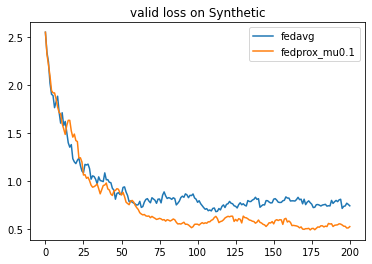

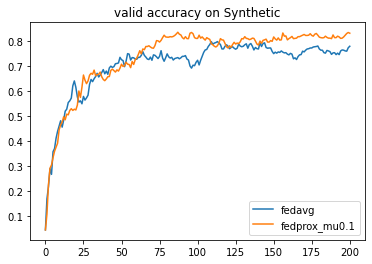

In [8]:
import flgo.experiment.analyzer
analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg', 'fedprox']
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'val_loss'}, 'fig_option':{'title':'valid loss on Synthetic'}},
            {'args':{'x': 'communication_round', 'y':'val_accuracy'},  'fig_option':{'title':'valid accuracy on Synthetic'}},
        ]
    }
}
flgo.experiment.analyzer.show(analysis_plan)

The result tells that FedProx has superior performance than FedAvg under this setting of data heterogeneity.

# 1.4 Model Configuration

This section introduces how to change the model. Far now, we only train the default model for each benchmark (e.g. CNN for mnist_classification). For most of the benchmarks, we have provided several popular models that can be easily used by replacing the parameter **model** in `flgo.init`. We show the usage by the following example.

## 1.4.1 Example: Select model for MNIST

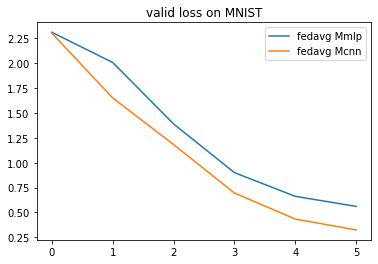

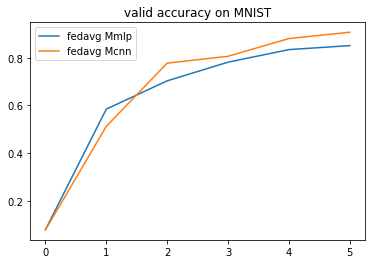

In [10]:
import flgo.benchmark.mnist_classification.model.cnn as cnn
import flgo.benchmark.mnist_classification.model.mlp as mlp
import flgo.algorithm.fedavg as fedavg
task = './mnist_iid' # this task has been generated in Example 2.1
cnn_runner = flgo.init(task, fedavg, option={'num_rounds':5, 'num_epochs':1, 'gpu':0}, model=cnn)
mlp_runner = flgo.init(task, fedavg, option={'num_rounds':5, 'num_epochs':1, 'gpu':0}, model=mlp)
cnn_runner.run()
mlp_runner.run()

# result analysis
import flgo.experiment.analyzer
analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg'],
        'filter':{'M':['cnn', 'mlp'], 'R':5}, # filter the result by the communication round R=5
        'legend_with':['M']
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'val_loss'}, 'fig_option':{'title':'valid loss on MNIST'}},
            {'args':{'x': 'communication_round', 'y':'val_accuracy'},  'fig_option':{'title':'valid accuracy on MNIST'}},
        ]
    }
}
flgo.experiment.analyzer.show(analysis_plan)

## 1.4.2 Customization on models

We now discuss the impletementation of models in our framework. Different from the centralized ML setting where there is only a model that transform the input to the output, the **model** in our framework should describe what and how the models are kept by different participants. This is because different parties in FL may have models with different architectures and paramters (e.g. personzalized FL, vertical FL, model-agnostic FL). In addition, the model sometimes could also be a significant part of particular methods. Therefore, we define the model as a class as follows:

In [13]:
class GeneralModel:
    @classmethod
    def init_local_module(cls, object):
        """init local models (e.g. personal models that cannot be shared) for the object according to its information"""
        pass
    
    @classmethod
    def init_global_module(cls, object):
        """init global models (e.g. sharable models) for the object according to its information"""
        pass

Now we construct a model and test it as the example.

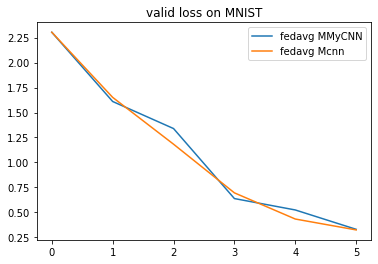

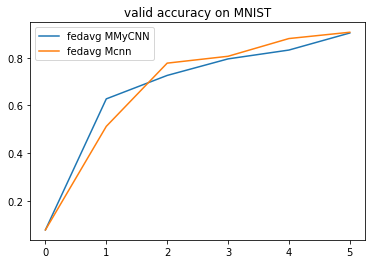

In [16]:
from torch import nn
import torch.nn.functional as F
from flgo.utils.fmodule import FModule

class CNNModel(FModule): # inherit from flgo.utils.fmodule.FModule instead of torch.nn.Module
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view((x.shape[0],28,28))
        x = x.unsqueeze(1)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def init_local_module(object):
    pass

def init_global_module(object):
    # In classical horizontal FL, only the server needs to trace the latest global and store it
    if 'Server' in object.get_classname():
        object.model = CNNModel().to(object.device)

class MyCNN:
    init_local_module = init_local_module
    init_global_module = init_global_module
    
mycnn_runner = flgo.init(task, fedavg, option={'num_rounds':5, 'num_epochs':1, 'gpu':0}, model=MyCNN)
mycnn_runner.run()

analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg'],
        'filter':{'M':['MyCNN', 'cnn'], 'R':5},
        'legend_with':['M']
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'val_loss'}, 'fig_option':{'title':'valid loss on MNIST'}},
            {'args':{'x': 'communication_round', 'y':'val_accuracy'},  'fig_option':{'title':'valid accuracy on MNIST'}},
        ]
    }
}
flgo.experiment.analyzer.show(analysis_plan)

The two CNNs of the same architecture has a similar performance in this example.

## 1.4.3 What is FModule?

`FModule` is a class that decorates the class `torch.nn.Module` to enable direct operations on models like add, sub. `FModule` directly inherits from `torch.nn.Module` and won't have any impact on its original characteristics. The only difference lies in that `FModule` allows the model-level operations by using operators +,-,* to obtain a new model. We show the usage of `FModule` by the following example.

### 1.4.3.1 Example: Model-level operators

In [26]:
from torch import nn
import torch.nn.functional as F
from flgo.utils.fmodule import FModule

class Model(FModule): 
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(3, 3, bias=False)

    def forward(self, x):
        return x

A = Model()
B = Model()

In [43]:
print("model A: ", A.fc.weight)
print("model B: ", B.fc.weight)

# add
C = A+B # C is a new instance of class Model and changes on C won't have any impact on A or B
print("C=A+B: {}", C.fc.weight)
print("Type of C:",C)

model A:  Parameter containing:
tensor([[ 0.2429, -0.4990,  0.1843],
        [-0.2553,  0.1664,  0.3536],
        [ 0.5772,  0.0578, -0.0694]], requires_grad=True)
model B:  Parameter containing:
tensor([[-0.4220, -0.3707, -0.2508],
        [-0.4888, -0.1267,  0.1310],
        [ 0.5714, -0.2370,  0.3410]], requires_grad=True)
C=A+B: {} Parameter containing:
tensor([[-0.1790, -0.8697, -0.0665],
        [-0.7441,  0.0397,  0.4845],
        [ 1.1486, -0.1792,  0.2716]], requires_grad=True)
Type of C: Model(
  (fc): Linear(in_features=3, out_features=3, bias=False)
)


In [56]:
# sub
print('A-B: \n', (A-B).fc.weight)
print('+++++++++++++++++++++++++++++++++++')
# scale
print('2*A: \n', (2*A).fc.weight)
print('+++++++++++++++++++++++++++++++++++')
# div
print('A/2: \n', (A/2).fc.weight)
print('+++++++++++++++++++++++++++++++++++')
# norm
print('||A||_2: \n', (A**2))
print('+++++++++++++++++++++++++++++++++++')
# neg
print('-A: \n', (-A).fc.weight)
print('+++++++++++++++++++++++++++++++++++')
# zeros-copy
print('A.zeros_like(): \n',A.zeros_like().fc.weight)
print('+++++++++++++++++++++++++++++++++++')
# dot
print("dot(A,B):\n", A.dot(B))
print('+++++++++++++++++++++++++++++++++++')
# cos-similarity
print("cos_sim(A,B):\n", A.cos_sim(B))
print('+++++++++++++++++++++++++++++++++++')
# size
print("size(A):\n", A.count_parameters())
print('+++++++++++++++++++++++++++++++++++')

A-B: 
 Parameter containing:
tensor([[ 0.6649, -0.1282,  0.4352],
        [ 0.2336,  0.2932,  0.2226],
        [ 0.0057,  0.2948, -0.4103]], requires_grad=True)
+++++++++++++++++++++++++++++++++++
2*A: 
 Parameter containing:
tensor([[ 0.4859, -0.9979,  0.3687],
        [-0.5105,  0.3329,  0.7072],
        [ 1.1543,  0.1156, -0.1388]], requires_grad=True)
+++++++++++++++++++++++++++++++++++
A/2: 
 Parameter containing:
tensor([[ 0.1215, -0.2495,  0.0922],
        [-0.1276,  0.0832,  0.1768],
        [ 0.2886,  0.0289, -0.0347]], requires_grad=True)
+++++++++++++++++++++++++++++++++++
||A||_2: 
 tensor(0.9493)
+++++++++++++++++++++++++++++++++++
-A: 
 Parameter containing:
tensor([[-0.2429,  0.4990, -0.1843],
        [ 0.2553, -0.1664, -0.3536],
        [-0.5772, -0.0578,  0.0694]], requires_grad=True)
+++++++++++++++++++++++++++++++++++
A.zeros_like(): 
 Parameter containing:
tensor([[0., -0., 0.],
        [-0., 0., 0.],
        [0., 0., -0.]], requires_grad=True)
+++++++++++++++++++++

Besides the model-level operators, we also implement some common functions on model-level.

In [59]:
import flgo.utils.fmodule as ff
# exp(A)
print('exp(A):\n', ff.exp(A).fc.weight)
print('+++++++++++++++++++++++++++++++++++')
# log(A)
print('log(A):\n', ff.log(A).fc.weight)
print('+++++++++++++++++++++++++++++++++++')
# model to 1-D vector
a = ff._model_to_tensor(A)
print('a = Vec(A):\n', a)
# 1-D tensor to model
print('A from a: \n',ff._model_from_tensor(a, A.__class__).fc.weight)
print('+++++++++++++++++++++++++++++++++++')
# model averaging
print('AVERAGE([A,B]):\n', ff._model_average([A,B]).fc.weight)
# model sum
print('SUM([A,B]):\n', ff._model_sum([A,B]).fc.weight)

exp(A):
 Parameter containing:
tensor([[1.2750, 0.6072, 1.2024],
        [0.7747, 1.1811, 1.4242],
        [1.7810, 1.0595, 0.9330]], requires_grad=True)
+++++++++++++++++++++++++++++++++++
log(A):
 Parameter containing:
tensor([[-1.4149,     nan, -1.6910],
        [    nan, -1.7931, -1.0396],
        [-0.5496, -2.8510,     nan]], requires_grad=True)
+++++++++++++++++++++++++++++++++++
a = Vec(A):
 tensor([ 0.2429, -0.4990,  0.1843, -0.2553,  0.1664,  0.3536,  0.5772,  0.0578,
        -0.0694])
A from a: 
 Parameter containing:
tensor([[ 0.2429, -0.4990,  0.1843],
        [-0.2553,  0.1664,  0.3536],
        [ 0.5772,  0.0578, -0.0694]], requires_grad=True)
+++++++++++++++++++++++++++++++++++
AVERAGE([A,B]):
 Parameter containing:
tensor([[-0.0895, -0.4348, -0.0333],
        [-0.3721,  0.0199,  0.2423],
        [ 0.5743, -0.0896,  0.1358]], requires_grad=True)
SUM([A,B]):
 Parameter containing:
tensor([[-0.1790, -0.8697, -0.0665],
        [-0.7441,  0.0397,  0.4845],
        [ 1.1486, 

## 1.4.4 Fast Customization

We further provide fast API to convert a model into federated one by writing only one line code

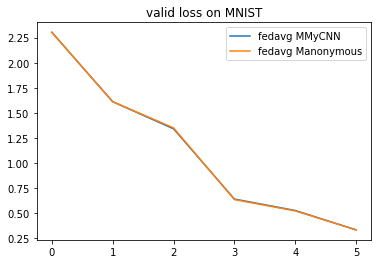

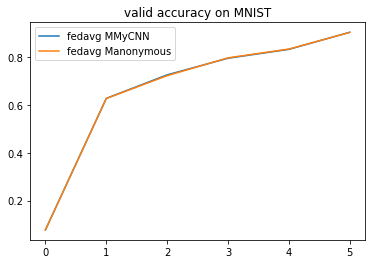

In [65]:
from torch import nn
import torch.nn.functional as F

class NewModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view((x.shape[0],28,28))
        x = x.unsqueeze(1)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = flgo.convert_model(NewModel) # the default value of model_name is 'anonymous'
mycnn_runner2 = flgo.init(task, fedavg, option={'num_rounds':5, 'num_epochs':1, 'gpu':0}, model=model)
mycnn_runner2.run()

analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg'],
        'filter':{'M':['MyCNN', 'anonymous'], 'R':5},
        'legend_with':['M']
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'val_loss'}, 'fig_option':{'title':'valid loss on MNIST'}},
            {'args':{'x': 'communication_round', 'y':'val_accuracy'},  'fig_option':{'title':'valid accuracy on MNIST'}},
        ]
    }
}
flgo.experiment.analyzer.show(analysis_plan)

# 1.5 Logger Customization 

This section introduces the usage of `Logger`. `Logger` is responsble for recording running-time variables of interest that can be very dependent on personal usage. We offer three key APIs to support different experiment purposes.

![Figure2](https://flgo-xmu.github.io/img/overview_exp.png)

In [68]:
import flgo.experiment.logger as fel
class Logger(fel.BasicLogger):
    def initialize(self):
        # initialize necessary variables BEFORE training starts
        pass
    
    def log_once(self):
        # will be carried out every K communication rounds DURING training process
        pass
    
    def organize_output(self):
        # organize output AFTER training ends
        pass

The three APIs are respectively responsible for customized operations before\during\after training. All the variables of interest should be recorded into `self.output` that will be finally saved as .json file. `self.output` is of type collections.defaultdict, and the default value of each key is an empty list. Now we take the following example to show how to customize `Logger`.

## 1.5.1 Example: Customization on Logger

In [69]:
import collections
import numpy as np
import copy

class MyLogger(fel.BasicLogger):
    def initialize(self, *args, **kwargs):
        self.optimal_model = copy.deepcopy(self.coordinator.model)
        self.optimal_test_loss = 9999

    def log_once(self):
        # evaluation on testing data
        test_metric = self.coordinator.test()
        for met_name, met_val in test_metric.items():
            self.output['test_' + met_name].append(met_val)
        # check whether the current model is the optimal
        if test_metric['loss']<self.optimal_test_loss:
            self.optimal_test_loss = test_metric['loss']
            self.optimal_model.load_state_dict(self.coordinator.model.state_dict())
        self.show_current_output()

    def organize_output(self):
        super().organize_output()
        # evaluation on clients' validation datasets
        all_metrics = collections.defaultdict(list)
        for c in self.participants:
            client_metrics = c.test(self.optimal_model, 'val')
            for met_name, met_val in client_metrics.items():
                all_metrics[met_name].append(met_val)
        for met_name, metval in all_metrics.items():
            self.output[met_name] = metval
        # compute the optimal\worst 30% metrics on validation datasets
        met_name = 'loss'
        all_valid_losses = sorted(all_metrics[met_name])
        k1 = int(0.3*len(self.participants))
        k2 = int(0.7*len(self.participants))
        self.output['worst_30_valid_loss'] = 1.0*sum(all_valid_losses[k2:])/k1
        self.output['best_30_valid_loss']  = 1.0*sum(all_valid_losses[:k1])/k1

import flgo.algorithm.fedavg as fedavg
import flgo.algorithm.qfedavg as qfedavg
import os
task = './test_synthetic' # this task has been generated in Sec.1.3.1

# running optimization
op = {'num_rounds':30, 'num_epochs':1, 'batch_size':8, 'learning_rate':0.1, 'proportion':1.0 ,'gpu':0, 'algo_para':0.1}
fedavg_runner = flgo.init(task, fedavg, option = op, Logger=MyLogger)
qffl_runner = flgo.init(task, qfedavg, option=op, Logger=MyLogger)
fedavg_runner.run()
qffl_runner.run()

# Result analysis
import flgo.experiment.analyzer as al
records = al.Selector({'task':task, 'header':['fedavg', 'qfedavg_q0.1',], 'filter':{'R':30, 'E':1, 'B':8, 'LR':0.1,'P':1.0}}).records[task]
for rec in records:
    wl = rec.data['worst_30_valid_loss']
    bl = rec.data['best_30_valid_loss']
    print('{}:(Worst is {}, Best is {})'.format(rec.data['option']['algorithm'], wl, bl))

2023-08-12 09:49:05,263 fflow.py init [line:545] INFO Initializing devices: cuda:0 will be used for this running.
2023-08-12 09:49:05,264 fflow.py init [line:547] INFO BENCHMARK:	flgo.benchmark.synthetic_regression
2023-08-12 09:49:05,265 fflow.py init [line:548] INFO TASK:			./test_synthetic
2023-08-12 09:49:05,266 fflow.py init [line:549] INFO MODEL:		flgo.benchmark.synthetic_regression.model.lr
2023-08-12 09:49:05,266 fflow.py init [line:550] INFO ALGORITHM:	fedavg
2023-08-12 09:49:05,450 fflow.py init [line:584] INFO SCENE:		horizontal FL with 1 <class 'flgo.algorithm.fedbase.BasicServer'>, 30 <class 'flgo.algorithm.fedbase.BasicClient'>
2023-08-12 09:49:05,469 fflow.py init [line:604] INFO SIMULATOR:	<class 'flgo.simulator.default_simulator.Simulator'>
2023-08-12 09:49:05,471 fflow.py init [line:613] INFO Ready to start.
2023-08-12 09:49:05,481 fflow.py init [line:545] INFO Initializing devices: cuda:0 will be used for this running.
2023-08-12 09:49:05,482 fflow.py init [line:547]

2023-08-12 09:49:20,594 3989513037.py log_once [line:19] INFO test_accuracy                 0.6656
2023-08-12 09:49:20,595 3989513037.py log_once [line:19] INFO test_loss                     1.0183
2023-08-12 09:49:20,596 fedbase.py run [line:251] INFO Eval Time Cost:               0.0190s
2023-08-12 09:49:21,605 fedbase.py run [line:246] INFO --------------Round 18--------------
2023-08-12 09:49:21,618 3989513037.py log_once [line:19] INFO test_accuracy                 0.6706
2023-08-12 09:49:21,619 3989513037.py log_once [line:19] INFO test_loss                     1.0006
2023-08-12 09:49:21,620 fedbase.py run [line:251] INFO Eval Time Cost:               0.0143s
2023-08-12 09:49:22,406 fedbase.py run [line:246] INFO --------------Round 19--------------
2023-08-12 09:49:22,419 3989513037.py log_once [line:19] INFO test_accuracy                 0.6394
2023-08-12 09:49:22,420 3989513037.py log_once [line:19] INFO test_loss                     1.0181
2023-08-12 09:49:22,420 fedbase.py r

2023-08-12 09:49:38,938 3989513037.py log_once [line:19] INFO test_accuracy                 0.4489
2023-08-12 09:49:38,939 3989513037.py log_once [line:19] INFO test_loss                     1.8295
2023-08-12 09:49:38,940 fedbase.py run [line:251] INFO Eval Time Cost:               0.0136s
2023-08-12 09:49:39,839 fedbase.py run [line:246] INFO --------------Round 8--------------
2023-08-12 09:49:39,852 3989513037.py log_once [line:19] INFO test_accuracy                 0.4522
2023-08-12 09:49:39,853 3989513037.py log_once [line:19] INFO test_loss                     1.7843
2023-08-12 09:49:39,854 fedbase.py run [line:251] INFO Eval Time Cost:               0.0137s
2023-08-12 09:49:40,804 fedbase.py run [line:246] INFO --------------Round 9--------------
2023-08-12 09:49:40,817 3989513037.py log_once [line:19] INFO test_accuracy                 0.4733
2023-08-12 09:49:40,818 3989513037.py log_once [line:19] INFO test_loss                     1.7150
2023-08-12 09:49:40,819 fedbase.py run

2023-08-12 09:50:00,035 fedbase.py run [line:251] INFO Eval Time Cost:               0.0141s
2023-08-12 09:50:01,256 fedbase.py run [line:246] INFO --------------Round 29--------------
2023-08-12 09:50:01,270 3989513037.py log_once [line:19] INFO test_accuracy                 0.7333
2023-08-12 09:50:01,271 3989513037.py log_once [line:19] INFO test_loss                     0.9870
2023-08-12 09:50:01,272 fedbase.py run [line:251] INFO Eval Time Cost:               0.0146s
2023-08-12 09:50:02,390 fedbase.py run [line:246] INFO --------------Round 30--------------
2023-08-12 09:50:02,404 3989513037.py log_once [line:19] INFO test_accuracy                 0.7367
2023-08-12 09:50:02,405 3989513037.py log_once [line:19] INFO test_loss                     0.9719
2023-08-12 09:50:02,406 fedbase.py run [line:251] INFO Eval Time Cost:               0.0145s
2023-08-12 09:50:02,406 fedbase.py run [line:257] INFO =================End==================
2023-08-12 09:50:02,407 fedbase.py run [line:25

fedavg:(Worst is 1.5370861026975844, Best is 0.15324175854523978)
qfedavg:(Worst is 1.5319330559836493, Best is 0.4078656468126509)


The results tells that qfedavg has a superior performance for the worst 30% clients but sacrifies model performance for the optimal 30% clients.